In [1]:
from drn_interactions.load import get_fig_dir, load_events, load_neurons_derived
from drn_interactions.spikes import SpikesHandlerMulti
from drn_interactions.fs_slow import SlowTSRespondersMixed, SlowTSRespondersAnova

import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import pandas as pd

In [2]:

sns.set_theme(context="poster", style="ticks")
outdir = get_fig_dir() / "base_shock"
outdir.mkdir(exist_ok=True, parents=True)
neurons = load_neurons_derived()
events = load_events("base_shock")
sessions = neurons[["session_name"]].drop_duplicates().merge(events[["session_name"]].drop_duplicates())["session_name"].unique()

# sessions = [s for s in sessions if s not in ("hamilton_04", "hamilton_36")]

In [5]:
# def get_sessions_with_post(sessions_in):
#     out = {}
#     for session in sessions_in:
#         out[session] = SpikesHandlerMulti(
#             block=["base_shock", "post_base_shock"], 
#             bin_width=10, 
#             session_names=[session],
#             t_start=t_start, 
#             t_stop=t_stop
#         ).spikes.spiketimes.max()
#     return out

# get_sessions_with_post(sessions)

# def plot_population(sessions_in):
#     _, axes = plt.subplots(nrows=len(sessions_in), figsize=(5, 20))
#     for i, session in enumerate(sessions_in):
#         df = SpikesHandlerMulti(
#             block=["base_shock", "post_base_shock"], 
#             bin_width=10, 
#             session_names=[session],
#             t_start=t_start, 
#             t_stop=t_stop
#         ).binned_piv
#         df.sum(axis=1).plot(ax=axes[i])
#         axes[i].set_title(session)
#     plt.tight_layout()

# # plot_population(sessions)

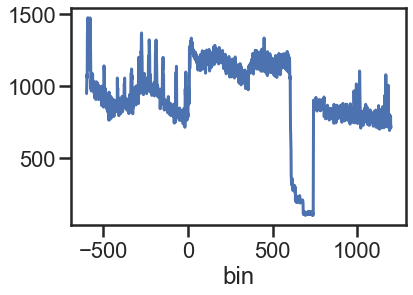

In [6]:
# Long timescale
t_start=-600
t_stop=1200
bin_width=1
session = sessions


sh = SpikesHandlerMulti(
    block=["base_shock", "post_base_shock"], 
    bin_width=bin_width, 
    session_names=sessions.tolist(),
    t_start=t_start, 
    t_stop=t_stop,
)
sh.binned_piv.sum(axis=1).plot()
df_binned_piv = sh.binned_piv.copy()

In [82]:
# mixed effects
mod = SlowTSRespondersMixed()
mod.get_responders(df_binned_piv, clusters = neurons[["neuron_id","wf_3"]])
print(mod.results_["anova"])

boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)
                SS      MS  NumDF     DenomDF  F-stat  P-val  Sig
block       41.836  20.918      2     235.157  28.359  0.000  ***
wf_3         0.000   0.000      2  311233.115   0.000  1.000     
block:wf_3   5.376   1.344      4     235.157   1.822  0.125     


boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)
            SS      MS  NumDF  DenomDF   F-stat  P-val  Sig
block  173.931  86.966      2  236.967  117.903    0.0  ***
  block  Estimate  2.5_ci  97.5_ci     SE   DF
1   pre     0.116   0.061    0.171  0.028  inf
2     1     0.247   0.182    0.313  0.033  inf
3     2    -0.364  -0.410   -0.317  0.024  inf
  Contrast  Estimate  2.5_ci  97.5_ci     SE   DF  Z-stat  P-val  Sig
1  pre - 1    -0.131  -0.264    0.002  0.057  inf  -2.315  0.054    .
2  pre - 2     0.480   0.386    0.573  0.040  inf  12.007  0.000  ***
3    1 - 2     0.611   0.493    0.730  0.051  inf  12.081  0.000  ***


<AxesSubplot:xlabel='Estimate'>

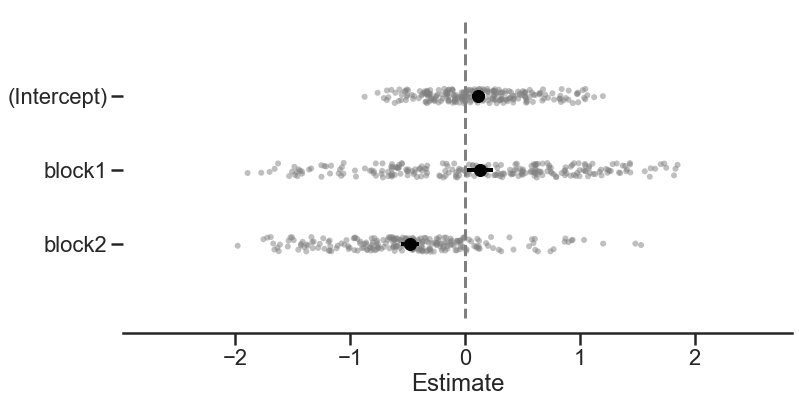

In [84]:
mod = SlowTSRespondersMixed()
mod.get_responders(df_binned_piv)
print(mod.results_["anova"])
print(mod.results_["emms"])
print(mod.results_["contrasts"])
mod.plot()

In [85]:
# Reapeated measures

mod = SlowTSRespondersAnova()
mod.get_responders(df_binned_piv=df_binned_piv, clusters=neurons[["neuron_id", "wf_3"]],)
mod.results_["anova"]

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,wf_3,0.000,2,235,0.000,2.178,0.116,NaN,0.018,NaN,NaN,NaN,NaN
1,block,49.251,2,470,24.625,84.712,0.000,0.0,0.265,0.871,False,0.852,0.0
2,Interaction,2.063,4,470,0.516,1.774,0.133,NaN,0.015,NaN,NaN,NaN,NaN


In [86]:
mod = SlowTSRespondersAnova()
mod.get_responders(df_binned_piv=df_binned_piv, fit_unit_level_models=True)
mod.results_["anova"]

100%|██████████| 238/238 [00:14<00:00, 16.44it/s]


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,block,2,474,84.162,0.0,0.0,0.262,0.871,False,0.852,0.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


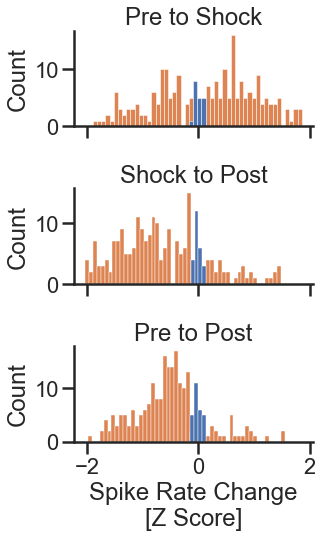

In [87]:
# plot results

_, ax = plt.subplots(nrows=3, figsize=(5, 8), sharey=False, sharex=True)
sns.set_theme(context="poster", style="ticks")
sns.histplot(data=mod.results_["pre_to_shock"].assign(sig=lambda x: x["p_adj"] < 0.05), x="diff_inv", hue="sig", ax=ax[0], alpha=1, bins=50)

sns.histplot(data=mod.results_["shock_to_post"].assign(sig=lambda x: x["p_adj"] < 0.05), x="diff_inv", hue="sig", ax=ax[1], alpha=1, bins=50)

sns.histplot(data=mod.results_["pre_to_post"].assign(sig=lambda x: x["p_adj"] < 0.05), x="diff_inv", hue="sig", ax=ax[2], alpha=1, bins=50)
ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()

ax[0].set_title("Pre to Shock")
ax[1].set_title("Shock to Post")
ax[2].set_title("Pre to Post")

ax[2].set_xlabel("Spike Rate Change\n[Z Score]")
sns.despine()
plt.tight_layout()